In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Train shape: (48000, 16)
Test shape: (12000, 14)


,Unnamed: 0,ID,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,1402,1402,5.993951,7.370240,0.506482,0.649901,5.460601,-1.862459,-1.838752,-1.759390,0.088862,0.910879,0.673066,0.825260,-0.015141,stable
1,59458,59458,9.152308,8.052565,9.857154,6.948056,3.812286,-1.143548,-0.762620,-1.906119,0.145046,0.519798,0.951724,0.441578,0.059299,unstable
2,33100,33100,7.816634,5.784760,9.890237,3.313459,3.093326,-0.945700,-1.125678,-1.021949,0.715187,0.868356,0.216808,0.461924,0.051024,unstable
3,27281,27281,7.235424,6.332835,2.814238,0.502049,4.250813,-1.174872,-1.223738,-1.852202,0.667283,0.097131,0.718194,0.896757,-0.020970,stable
4,20808,20808,6.176707,1.792532,2.631187,6.380292,3.148133,-1.369339,-0.952775,-0.826019,0.138104,0.510533,0.330242,0.661512,-0.023525,stable


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  48000 non-null  int64  
 1   ID          48000 non-null  int64  
 2   tau1        48000 non-null  float64
 3   tau2        48000 non-null  float64
 4   tau3        48000 non-null  float64
 5   tau4        48000 non-null  float64
 6   p1          48000 non-null  float64
 7   p2          48000 non-null  float64
 8   p3          48000 non-null  float64
 9   p4          48000 non-null  float64
 10  g1          48000 non-null  float64
 11  g2          48000 non-null  float64
 12  g3          48000 non-null  float64
 13  g4          48000 non-null  float64
 14  stab        48000 non-null  float64
 15  stabf       48000 non-null  object 
dtypes: float64(13), int64(2), object(1)
memory usage: 5.9+ MB
None
         Unnamed: 0            ID          tau1          tau2          tau3  \
count 

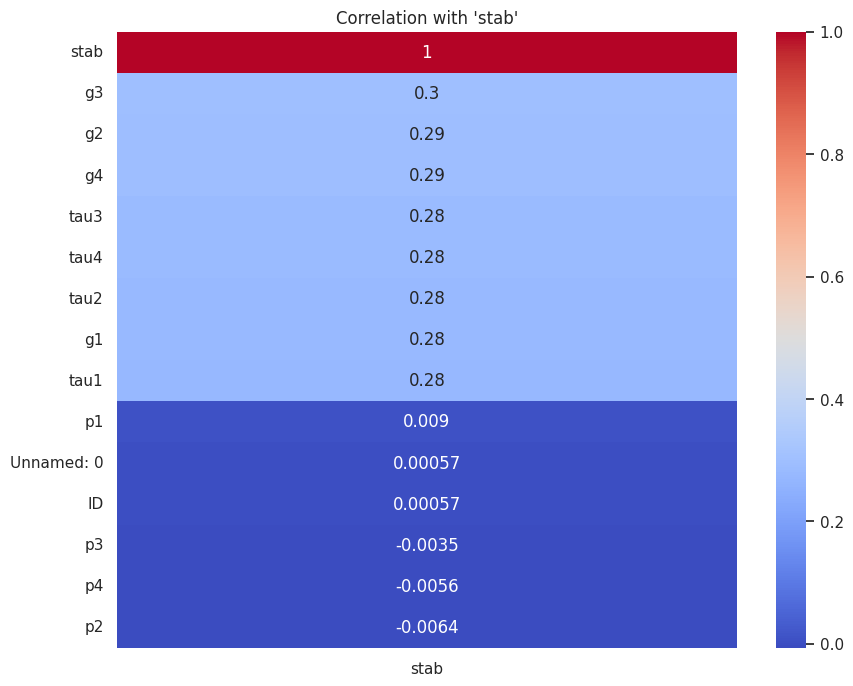

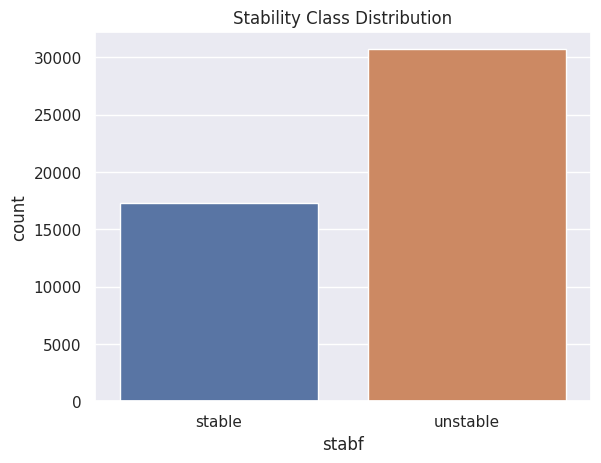

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 38400, number of used features: 14
[LightGBM] [Info] Start training from score 0.015766
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 38400, number of used features: 14
[LightGBM] [Info] Start training from score 0.015812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 38400, number of used features: 14
[LightGBM] [Info] Start tra

,ID,stab,OPTIMAL VALUE,target
0,33437,0.374540,0.654306,0.048625
1,1158,0.950714,0.080033,0.012940
2,49582,0.731994,0.242330,0.022188
3,18239,0.598658,0.773679,0.030041
4,18948,0.156019,0.528686,-0.017534


In [9]:
# Grid Optimization Challenge - IIIT Bhagalpur (Enyugma)
# Complete Kaggle Notebook

# ===============================
# 1. Imports & Setup
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

sns.set()
RANDOM_STATE = 42

# ===============================
# 2. Load the Data
# ===============================
# UPDATE THIS PATH TO MATCH ACTUAL KAGGLE FOLDER
DATA_PATH = "/kaggle/input/grid-optimization-data-v1-0"  # replace with correct folder

train = pd.read_csv(f"{DATA_PATH}/train.csv")
test = pd.read_csv(f"{DATA_PATH}/test.csv")
submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
display(train.head())

# ===============================
# 3. Exploratory Data Analysis
# ===============================
# Basic info
print(train.info())
print(train.describe())

# Select only numeric columns for correlation
numeric_cols = train.select_dtypes(include=[np.number])
correlation = numeric_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation[['stab']].sort_values(by='stab', ascending=False), annot=True, cmap="coolwarm")
plt.title("Correlation with 'stab'")
plt.show()

# Stability class distribution
sns.countplot(data=train, x='stabf')
plt.title("Stability Class Distribution")
plt.show()

# ===============================
# 4. Preprocessing
# ===============================
# Drop 'stabf' and separate features/target
features = [col for col in train.columns if col not in ['stab', 'stabf']]
X = train[features]
y = train['stab']
X_test = test[features]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# ===============================
# 5. Model Training - LightGBM
# ===============================
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=RANDOM_STATE)

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores = cross_val_score(lgb_model, X_scaled, y, scoring='neg_root_mean_squared_error', cv=cv)
print(f"CV RMSE: {-scores.mean():.4f}")

# Train on full data
lgb_model.fit(X_scaled, y)

# ===============================
# 6. Prediction & Submission
# ===============================
preds = lgb_model.predict(X_test_scaled)
submission['target'] = preds
submission.to_csv("submission.csv", index=False)
submission.head()
